In [22]:
import pandas as pd
import warnings

warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tabulate import tabulate

In [11]:
df = pd.read_csv('input/mbti_data_clean.csv')

df.head()

,type,clean_posts,E_I,S_N,T_F,J_P
0,INFJ,enfp and intj moments sportscenter not top te...,0,0,0,1
1,ENTP,i m finding the lack of me in these posts ver...,1,0,1,0
2,INTP,good one of course to which i say i know that...,0,0,1,0
3,INTJ,dear intp i enjoyed our conversation the othe...,0,0,1,1
4,ENTJ,you re fired that s another silly misconcepti...,1,0,1,1


In [12]:
# Build the vocabulary from 1500 words that are not common words or MBTI personalities
vectorizer = CountVectorizer(stop_words = ['and','the','to','of','infj','entp','intp','intj','entj','enfj','infp','enfp','isfp','istp','isfj','istj','estp','esfp','estj','esfj','infjs','entps','intps','intjs','entjs','enfjs','infps','enfps','isfps','istps','isfjs','istjs','estps','esfps','estjs','esfjs'], max_features=1500, analyzer='word', max_df=0.8, min_df=0.1)

corpus = df['clean_posts'].values.reshape(1,-1).tolist()[0]

vectorizer.fit(corpus)

X_cnt = vectorizer.fit_transform(corpus)

# Transform the count matrix to a tf-idf representation
tfizer = TfidfTransformer()
tfizer.fit(X_cnt)

X = tfizer.fit_transform(X_cnt).toarray()

all_words = vectorizer.get_feature_names()

n_words = len(all_words)

X_df = pd.DataFrame.from_dict({w: X[:, i] for i, w in enumerate(all_words)})

In [13]:
def balance_random_oversample(X_train, y_train):
    oversampler = RandomOverSampler(sampling_strategy=0.9, random_state=0)
    
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
    
    return X_resampled, y_resampled

def balance_smote_oversample(X_train, y_train):
    oversampler = SMOTE(random_state=0)
    
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
    
    return X_resampled, y_resampled

def balance_smote_oversample_random_undersample(X_train, y_train):
    oversampler = SMOTE(sampling_strategy=0.9, random_state=0) 
    undersampler = RandomUnderSampler(sampling_strategy=0.9, random_state=0)

    # Applying oversampler to oversample the minority class
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

    # Applying undersampler to reduce the majority class
    X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)

    return X_resampled, y_resampled

def balance_borderlinesmote_oversample(X_train, y_train):
    oversampler = BorderlineSMOTE(random_state=0)
    
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
    
    return X_resampled, y_resampled

In [14]:
def train_test_split_data(class_name, resampler=None):
  y_df = df[class_name]
  
  if resampler == None:
    X_cl = X_df
    y_cl = y_df
  else:
    X_cl, y_cl = resampler(X_df, y_df)

  X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size=0.2, random_state=42, stratify=y_cl)

  return X_cl_train, X_cl_test, y_cl_train, y_cl_test

In [15]:
# E_I balanced dataset class
X_train_EI, X_test_EI, y_train_EI, y_test_EI = train_test_split_data('E_I', balance_random_oversample)

# S_N balanced dataset class
X_train_SN, X_test_SN, y_train_SN, y_test_SN = train_test_split_data('S_N', balance_random_oversample)

# T_F balanced dataset class
X_train_TF, X_test_TF, y_train_TF, y_test_TF = train_test_split_data('T_F')

# J_P balanced dataset class
X_train_JP, X_test_JP, y_train_JP, y_test_JP = train_test_split_data('J_P', balance_smote_oversample)

In [109]:
# Classifiers hyper parameters
svm_params = {
  'C': [0.1, 1, 10],
  'kernel': ['linear', 'rbf'],
  'gamma': ['scale', 'auto']  # Only relevant for rbf kernel
}

lgbm_params = {
  'n_estimators': [100, 200, 300],
  'learning_rate': [0.01, 0.05, 0.1],
  'max_depth': [5, 10, -1]
}

rf_params = {
  'n_estimators': [100, 200, 500],
  'max_depth': [10, 20, None],
  'min_samples_split': [2, 5]
}

lr_params = {
  'C': [0.1, 1, 10],
  'solver': ['lbfgs', 'saga']
}

xgb_params = {
  'n_estimators': [100, 200, 300],
  'learning_rate': [0.01, 0.05, 0.1],
  'max_depth': [3, 5, 10]
}

In [144]:
# Define GridSearchCV for RandomForest
grid_rf = GridSearchCV(
  estimator = RandomForestClassifier(random_state=42),
  param_grid = rf_params, 
  cv = 5, 
  scoring = 'f1', 
  n_jobs = -1
)

# Define GridSearchCV for SVM
grid_svm = GridSearchCV(
  estimator = SVC(probability=True, random_state=42),
  param_grid = svm_params, 
  cv = 5, 
  scoring = 'f1', 
  n_jobs = -1
)

# Define GridSearchCV for LogisticRegression
grid_lr = GridSearchCV(
  estimator = LogisticRegression(random_state=42),
  param_grid = lr_params,
  cv = 5, 
  scoring = 'f1', 
  n_jobs = -1
)

# Define GridSearchCV for XGB
grid_xgb = GridSearchCV(
  estimator = XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='logloss'),
  param_grid = xgb_params, 
  cv = 5, 
  scoring = 'f1', 
  n_jobs = -1
)

In [121]:
def best_estimator(grid_est, X_train, y_train):
  grid_est.fit(X_train, y_train)

  best_est = grid_est.best_estimator_

  best_params = grid_est.best_params_

  results_est = grid_est.cv_results_

  return best_est, best_params, results_est

In [153]:
def best_estimator_report_rf(class_name, results_estimator, best_params):
  print('{:s} Class RandomForest Classifier Hyperparameters Test Report'.format(class_name), end="\n\n")

  rows = []
  for mean, params in zip(results_estimator['mean_test_score'], results_estimator['params']):
      rows.append([mean, params['n_estimators'], params['max_depth'], params['min_samples_split']])

  headers = ["Mean F1 Score", "n_estimators", "Max Depth", "Min Samples Split"]

  print(tabulate(rows, headers=headers, tablefmt="grid"), end="\n\n")

  print("Best parameters for {:s} class RandomForest classifier: {}".format(class_name, best_params))

In [156]:
def best_estimator_report_svm(class_name, results_estimator, best_params):
  print('{:s} Class SVM Classifier Hyperparameters Test Report'.format(class_name), end="\n\n")
  
  rows = []
  # SVM has 'C', 'kernel', and optionally 'gamma'
  for mean, params in zip(results_estimator['mean_test_score'], results_estimator['params']):
      rows.append([mean, params['C'], params['kernel'], params.get('gamma', 'N/A')])

  headers = ["Mean F1 Score", "C", "Kernel", "Gamma"]
  
  print(tabulate(rows, headers=headers, tablefmt="grid"), end="\n\n")
  
  print("Best parameters for {:s} class SVM classifier: {}".format(class_name, best_params))

In [157]:
def best_estimator_report_lr(class_name, results_estimator, best_params):
    print('{:s} Class LogisticRegression Classifier Hyperparameters Test Report'.format(class_name), end="\n\n")
    
    rows = []
    # LogisticRegression has 'C' and 'solver'
    for mean, params in zip(results_estimator['mean_test_score'], results_estimator['params']):
        rows.append([mean, params['C'], params['solver']])

    headers = ["Mean F1 Score", "C", "Solver"]
    
    print(tabulate(rows, headers=headers, tablefmt="grid"), end="\n\n")
    
    print("Best parameters for {:s} class LogisticRegression classifier: {}".format(class_name, best_params))

In [158]:
def best_estimator_report_xgb(class_name, results_estimator, best_params):
    print('{:s} Class XGB Classifier Hyperparameters Test Report'.format(class_name), end="\n\n")
    
    rows = []
    # XGBoost has 'n_estimators', 'learning_rate', and 'max_depth'
    for mean, params in zip(results_estimator['mean_test_score'], results_estimator['params']):
        rows.append([mean, params['n_estimators'], params['learning_rate'], params['max_depth']])

    headers = ["Mean F1 Score", "n_estimators", "Learning Rate", "Max Depth"]
    
    print(tabulate(rows, headers=headers, tablefmt="grid"), end="\n\n")
    
    print("Best parameters for {:s} class XGB classifier: {}".format(class_name, best_params))

In [134]:
#########################################################
# E_I RandomForest Classifier Hyperparameters Tunning ###
#########################################################

best_estimator_ei, best_params_ei, results_estimator_ei = best_estimator(grid_rf, X_train_EI, y_train_EI)

In [154]:
best_estimator_report_rf('E_I', results_estimator_ei, best_params_ei)

E_I Class RandomForest Classifier Hyperparameters Test Report

+-----------------+----------------+-------------+---------------------+
|   Mean F1 Score |   n_estimators |   Max Depth |   Min Samples Split |
+=================+================+=============+=====================+
|        0.853498 |            100 |          10 |                   2 |
+-----------------+----------------+-------------+---------------------+
|        0.864754 |            200 |          10 |                   2 |
+-----------------+----------------+-------------+---------------------+
|        0.870891 |            500 |          10 |                   2 |
+-----------------+----------------+-------------+---------------------+
|        0.853188 |            100 |          10 |                   5 |
+-----------------+----------------+-------------+---------------------+
|        0.862153 |            200 |          10 |                   5 |
+-----------------+----------------+-------------+-----------

In [145]:
  #########################################################
  # S_N RandomForest Classifier Hyperparameters Tunning ###
  #########################################################

best_estimator_sn, best_params_sn, results_estimator_sn = best_estimator(grid_rf, X_train_SN, y_train_SN)

In [155]:
best_estimator_report_rf('S_N', results_estimator_sn, best_params_sn)

S_N Class RandomForest Classifier Hyperparameters Test Report

+-----------------+----------------+-------------+---------------------+
|   Mean F1 Score |   n_estimators |   Max Depth |   Min Samples Split |
+=================+================+=============+=====================+
|        0.948618 |            100 |          10 |                   2 |
+-----------------+----------------+-------------+---------------------+
|        0.952902 |            200 |          10 |                   2 |
+-----------------+----------------+-------------+---------------------+
|        0.95571  |            500 |          10 |                   2 |
+-----------------+----------------+-------------+---------------------+
|        0.943683 |            100 |          10 |                   5 |
+-----------------+----------------+-------------+---------------------+
|        0.950397 |            200 |          10 |                   5 |
+-----------------+----------------+-------------+-----------

In [147]:
################################################
# T_F SVM Classifier Hyperparameters Tunning ###
################################################

best_estimator_tf, best_params_tf, results_estimator_tf = best_estimator(grid_svm, X_train_TF, y_train_TF)

In [159]:
best_estimator_report_svm('T_F', results_estimator_tf, best_params_tf)

T_F Class SVM Classifier Hyperparameters Test Report

+-----------------+------+----------+---------+
|   Mean F1 Score |    C | Kernel   | Gamma   |
+=================+======+==========+=========+
|       0.711918  |  0.1 | linear   | scale   |
+-----------------+------+----------+---------+
|       0.602411  |  0.1 | rbf      | scale   |
+-----------------+------+----------+---------+
|       0.711918  |  0.1 | linear   | auto    |
+-----------------+------+----------+---------+
|       0         |  0.1 | rbf      | auto    |
+-----------------+------+----------+---------+
|       0.732134  |  1   | linear   | scale   |
+-----------------+------+----------+---------+
|       0.741693  |  1   | rbf      | scale   |
+-----------------+------+----------+---------+
|       0.732134  |  1   | linear   | auto    |
+-----------------+------+----------+---------+
|       0         |  1   | rbf      | auto    |
+-----------------+------+----------+---------+
|       0.711427  | 10   | linear 

In [160]:
###############################################
# J_P Subclassfiers Hyperparameters Tunning ###
###############################################

# J_P VotingClassifier SVM Subclassifier
best_estimator_jp_svm, best_params_jp_svm, results_estimator_jp_svm = best_estimator(grid_svm, X_train_JP, y_train_JP)

In [161]:
best_estimator_report_svm('J_P', results_estimator_jp_svm, best_params_jp_svm)

J_P Class SVM Classifier Hyperparameters Test Report

+-----------------+------+----------+---------+
|   Mean F1 Score |    C | Kernel   | Gamma   |
+=================+======+==========+=========+
|        0.659768 |  0.1 | linear   | scale   |
+-----------------+------+----------+---------+
|        0.548206 |  0.1 | rbf      | scale   |
+-----------------+------+----------+---------+
|        0.659768 |  0.1 | linear   | auto    |
+-----------------+------+----------+---------+
|        0.60484  |  0.1 | rbf      | auto    |
+-----------------+------+----------+---------+
|        0.669581 |  1   | linear   | scale   |
+-----------------+------+----------+---------+
|        0.705943 |  1   | rbf      | scale   |
+-----------------+------+----------+---------+
|        0.669581 |  1   | linear   | auto    |
+-----------------+------+----------+---------+
|        0.60484  |  1   | rbf      | auto    |
+-----------------+------+----------+---------+
|        0.664147 | 10   | linear 

In [162]:
# J_P VotingClassifier RandomForest Subclassifier
best_estimator_jp_rf, best_params_jp_rf, results_estimator_jp_rf = best_estimator(grid_rf, X_train_JP, y_train_JP)

In [164]:
best_estimator_report_rf('J_P', results_estimator_jp_rf, best_params_jp_rf)

J_P Class RandomForest Classifier Hyperparameters Test Report

+-----------------+----------------+-------------+---------------------+
|   Mean F1 Score |   n_estimators |   Max Depth |   Min Samples Split |
+=================+================+=============+=====================+
|        0.650572 |            100 |          10 |                   2 |
+-----------------+----------------+-------------+---------------------+
|        0.653477 |            200 |          10 |                   2 |
+-----------------+----------------+-------------+---------------------+
|        0.653652 |            500 |          10 |                   2 |
+-----------------+----------------+-------------+---------------------+
|        0.649974 |            100 |          10 |                   5 |
+-----------------+----------------+-------------+---------------------+
|        0.648108 |            200 |          10 |                   5 |
+-----------------+----------------+-------------+-----------

In [165]:
# J_P VotingClassifier LogisticRegression Subclassifier
best_estimator_jp_lr, best_params_jp_lr, results_estimator_jp_lr = best_estimator(grid_lr, X_train_JP, y_train_JP)

In [166]:
best_estimator_report_lr('J_P', results_estimator_jp_lr, best_params_jp_lr)

J_P Class LogisticRegression Classifier Hyperparameters Test Report

+-----------------+------+----------+
|   Mean F1 Score |    C | Solver   |
+=================+======+==========+
|        0.660684 |  0.1 | lbfgs    |
+-----------------+------+----------+
|        0.660518 |  0.1 | saga     |
+-----------------+------+----------+
|        0.67017  |  1   | lbfgs    |
+-----------------+------+----------+
|        0.67017  |  1   | saga     |
+-----------------+------+----------+
|        0.659421 | 10   | lbfgs    |
+-----------------+------+----------+
|        0.659421 | 10   | saga     |
+-----------------+------+----------+

Best parameters for J_P class LogisticRegression classifier: {'C': 1, 'solver': 'lbfgs'}


In [167]:
# J_P VotingClassifier XGB Subclassifier
best_estimator_jp_xgb, best_params_jp_xgb, results_estimator_jp_xgb = best_estimator(grid_xgb, X_train_JP, y_train_JP)

In [168]:
best_estimator_report_xgb('J_P', results_estimator_jp_xgb, best_params_jp_xgb)

J_P Class XGB Classifier Hyperparameters Test Report

+-----------------+----------------+-----------------+-------------+
|   Mean F1 Score |   n_estimators |   Learning Rate |   Max Depth |
+=================+================+=================+=============+
|        0.635651 |            100 |            0.01 |           3 |
+-----------------+----------------+-----------------+-------------+
|        0.651247 |            200 |            0.01 |           3 |
+-----------------+----------------+-----------------+-------------+
|        0.655287 |            300 |            0.01 |           3 |
+-----------------+----------------+-----------------+-------------+
|        0.649708 |            100 |            0.01 |           5 |
+-----------------+----------------+-----------------+-------------+
|        0.66428  |            200 |            0.01 |           5 |
+-----------------+----------------+-----------------+-------------+
|        0.667603 |            300 |            0

In [ ]:
# *****************
# Tuned models ****
# *****************

# tuned EI classifeier 
clf_tuned_EI = best_estimator_ei

# tuned SN classifeier 
clf_tuned_SN = best_estimator_sn

# tuned TF classifeier 
clf_tuned_TF = best_estimator_tf

# tuned JP classifeier 
clf_tuned_JP = VotingClassifier(estimators=[
  ('svm', best_estimator_jp_svm),
  ('rf', best_estimator_jp_rf),
  ('lr', best_estimator_jp_lr),
  ('xgb', best_estimator_jp_xgb)
], voting='soft')

In [175]:
##########################################
# Class Tuned Model Performance Test #####
##########################################

def class_tuned_model_test(class_name, model_classifier, X_train, X_test, y_train, y_test):
    print('{:s} Class Tuned Model Test Report'.format(class_name), end="\n\n")

    # Cross-Validation and Performance Stability
    ei_cv_scores = cross_val_score(model_classifier, X_train, y_train, cv=5, scoring='f1')
    
    print('F1 Cross-Validation Scores: {:s}'.format(str(ei_cv_scores)))
    print('F1 Mean: {:n}'.format(ei_cv_scores.mean()), end="\n\n")

    # Performance on Test Data
    model_classifier.fit(X_train, y_train)

    y_pred = model_classifier.predict(X_test)

    model_report = classification_report(y_test, y_pred, output_dict=True)

    model_report_headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
    model_report_rows = [
      ["0", model_report["0"]["precision"], model_report["0"]["recall"], model_report["0"]["f1-score"], model_report["0"]["support"]],
      ["1", model_report["1"]["precision"], model_report["1"]["recall"], model_report["1"]["f1-score"], model_report["1"]["support"]],
      ["Accuracy", "", "", model_report["accuracy"], ""],
      ["Macro Avg", model_report["macro avg"]["precision"], model_report["macro avg"]["recall"], model_report["macro avg"]["f1-score"], model_report["macro avg"]["support"]],
      ["Weighted Avg", model_report["weighted avg"]["precision"], model_report["weighted avg"]["recall"], model_report["weighted avg"]["f1-score"], model_report["weighted avg"]["support"]],
    ]

    print(tabulate(model_report_rows, headers=model_report_headers, tablefmt="grid"))

In [177]:
class_tuned_model_test('E_I', clf_tuned_EI, X_train_EI, X_test_EI, y_train_EI, y_test_EI)

E_I Class Tuned Model Test Report

F1 Cross-Validation Scores: [0.921797   0.91214326 0.9205114  0.91512085 0.91573034]
F1 Mean: 0.917061

+--------------+--------------------+--------------------+------------+-----------+
| Class        | Precision          | Recall             |   F1-Score | Support   |
+==============+====================+====================+============+===========+
| 0            | 0.9333800841514727 | 0.997003745318352  |   0.964143 | 1335      |
+--------------+--------------------+--------------------+------------+-----------+
| 1            | 0.9963996399639964 | 0.9209650582362728 |   0.957198 | 1202      |
+--------------+--------------------+--------------------+------------+-----------+
| Accuracy     |                    |                    |   0.960978 |           |
+--------------+--------------------+--------------------+------------+-----------+
| Macro Avg    | 0.9648898620577345 | 0.9589844017773124 |   0.960671 | 2537      |
+--------------+-----

In [178]:
class_tuned_model_test('S_N', clf_tuned_SN, X_train_SN, X_test_SN, y_train_SN, y_test_SN)

S_N Class Tuned Model Test Report

F1 Cross-Validation Scores: [0.98455779 0.98780488 0.98403756 0.98876404 0.98541176]
F1 Mean: 0.986115

+--------------+--------------------+--------------------+------------+-----------+
| Class        | Precision          | Recall             |   F1-Score | Support   |
+==============+====================+====================+============+===========+
| 0            | 0.9946702198534311 | 0.9979946524064172 |   0.99633  | 1496      |
+--------------+--------------------+--------------------+------------+-----------+
| 1            | 0.9977628635346756 | 0.9940564635958395 |   0.995906 | 1346      |
+--------------+--------------------+--------------------+------------+-----------+
| Accuracy     |                    |                    |   0.996129 |           |
+--------------+--------------------+--------------------+------------+-----------+
| Macro Avg    | 0.9962165416940534 | 0.9960255580011284 |   0.996118 | 2842      |
+--------------+-----

In [179]:
class_tuned_model_test('T_F', clf_tuned_TF, X_train_TF, X_test_TF, y_train_TF, y_test_TF)

T_F Class Tuned Model Test Report

F1 Cross-Validation Scores: [0.72859451 0.74718196 0.73413655 0.73642173 0.76212833]
F1 Mean: 0.741693

+--------------+--------------------+--------------------+------------+-----------+
| Class        | Precision          | Recall             |   F1-Score | Support   |
+==============+====================+====================+============+===========+
| 0            | 0.7851239669421488 | 0.8093716719914803 |   0.797063 | 939       |
+--------------+--------------------+--------------------+------------+-----------+
| 1            | 0.7666232073011734 | 0.7386934673366834 |   0.752399 | 796       |
+--------------+--------------------+--------------------+------------+-----------+
| Accuracy     |                    |                    |   0.776945 |           |
+--------------+--------------------+--------------------+------------+-----------+
| Macro Avg    | 0.7758735871216611 | 0.7740325696640818 |   0.774731 | 1735      |
+--------------+-----

In [181]:
class_tuned_model_test('J_P', clf_tuned_JP, X_train_JP, X_test_JP, y_train_JP, y_test_JP)

J_P Class Tuned Model Test Report

F1 Cross-Validation Scores: [0.71029225 0.73142857 0.71726755 0.72461929 0.74554707]
F1 Mean: 0.725831

+--------------+--------------------+--------------------+------------+-----------+
| Class        | Precision          | Recall             |   F1-Score | Support   |
+==============+====================+====================+============+===========+
| 0            | 0.7276559865092749 | 0.8226882745471878 |   0.77226  | 1049      |
+--------------+--------------------+--------------------+------------+-----------+
| 1            | 0.7958287596048299 | 0.691793893129771  |   0.740174 | 1048      |
+--------------+--------------------+--------------------+------------+-----------+
| Accuracy     |                    |                    |   0.757272 |           |
+--------------+--------------------+--------------------+------------+-----------+
| Macro Avg    | 0.7617423730570524 | 0.7572410838384794 |   0.756217 | 2097      |
+--------------+-----

In [18]:
#################################
# Tuned Model Accuracy Test #####
#################################

df_t = pd.read_csv('output/mbti_data_clean_classified_tuned.csv')

# Calculate accuracy for each dimension
comparison_results = {}
for original, classified in zip(['E_I', 'S_N', 'T_F', 'J_P'], ['e_i', 's_n', 't_f', 'j_p']):
    accuracy = (df_t[original] == df_t[classified]).mean()
    comparison_results[original] = accuracy

# Display results
for dimension, accuracy in comparison_results.items():
    print(f"Accuracy for {dimension}: {accuracy:.2%}")

Accuracy for E_I: 99.09%
Accuracy for S_N: 99.92%
Accuracy for T_F: 91.78%
Accuracy for J_P: 94.13%


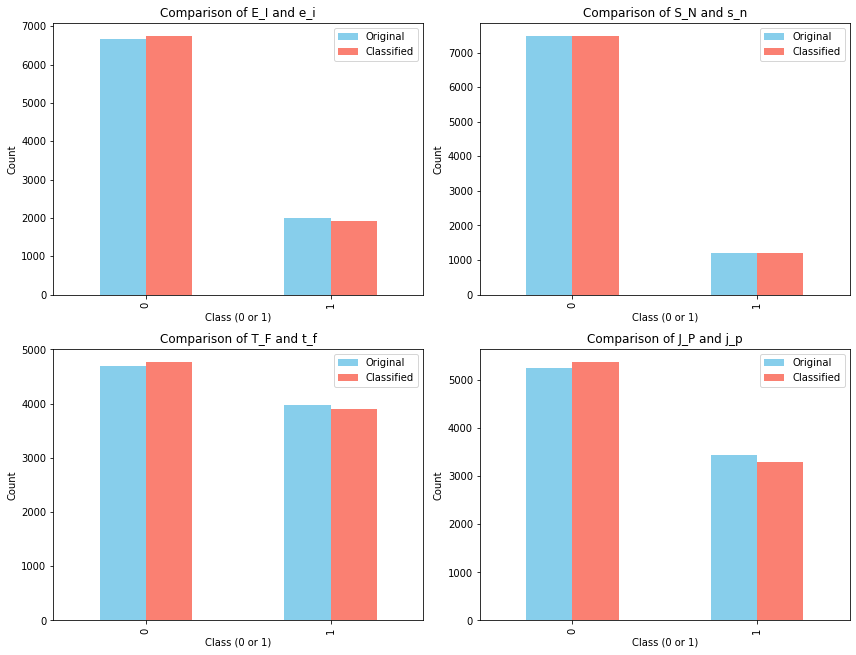

In [49]:
# Compare models before and after tuning
columns_to_compare = [('E_I', 'e_i'), ('S_N', 's_n'), ('T_F', 't_f'), ('J_P', 'j_p')]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for (orig_col, class_col), ax in zip(columns_to_compare, axes.flatten()):
    # Count the occurrences of 0 and 1 for both original and classified columns
    counts_orig = df_t[orig_col].value_counts().sort_index()
    counts_class = df_t[class_col].value_counts().sort_index()
    
    counts_df = pd.DataFrame({'Original': counts_orig, 'Classified': counts_class}).fillna(0)
    
    # Plot the counts as side-by-side bars
    counts_df.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
    ax.set_title(f'Comparison of {orig_col} and {class_col}')
    ax.set_xlabel('Class (0 or 1)')
    ax.set_ylabel('Count')
    ax.legend(loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [50]:
# Generate the classification report
report = classification_report(df_t['type'], df_t['mbti'], zero_division=0, output_dict=True)

df_report = pd.DataFrame(report).transpose()
df_report = df_report.rename(columns={"precision": "Precision", "recall": "Recall", "f1-score": "F1-Score", "support": "Support"})

table = tabulate(df_report, headers="keys", tablefmt="grid", floatfmt=".2f")

print(table)

+--------------+-------------+----------+------------+-----------+
|              |   Precision |   Recall |   F1-Score |   Support |
+==============+=============+==========+============+===========+
| ENFJ         |        0.76 |     0.88 |       0.81 |    190.00 |
+--------------+-------------+----------+------------+-----------+
| ENFP         |        0.89 |     0.87 |       0.88 |    675.00 |
+--------------+-------------+----------+------------+-----------+
| ENTJ         |        0.85 |     0.73 |       0.79 |    231.00 |
+--------------+-------------+----------+------------+-----------+
| ENTP         |        0.91 |     0.85 |       0.88 |    685.00 |
+--------------+-------------+----------+------------+-----------+
| ESFJ         |        0.82 |     0.88 |       0.85 |     42.00 |
+--------------+-------------+----------+------------+-----------+
| ESFP         |        0.79 |     0.77 |       0.78 |     48.00 |
+--------------+-------------+----------+------------+--------

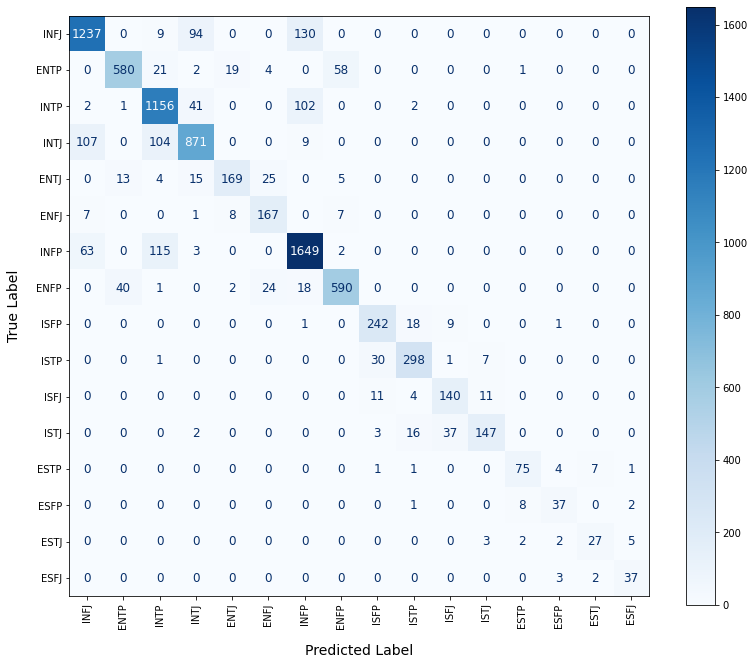

In [45]:
# Generate and display confusion matrix
cm = confusion_matrix(df_t['type'], df_t['mbti'], labels=df['type'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['type'].unique())

fig, ax = plt.subplots(figsize=(13, 11))

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax, colorbar=True)

plt.xlabel("Predicted Label", fontsize=14, labelpad=15)
plt.ylabel("True Label", fontsize=14, labelpad=15)

# Adjust the font size of annotations inside the confusion matrix cells
for text in disp.text_.ravel():
    text.set_fontsize(12)

plt.show()